In [1]:
## A test for the SSE in the middle
#%% Load data
import tensorflow.compat.v1 as tf
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
sess = tf.Session(config=config)
import numpy as np
import h5py
import os
import matplotlib.pyplot as plt
SNR='3+4+5_560kdc3'
## load data
file =  '*****/pinkishrednoise_data_up'
os.chdir(file)
with h5py.File('data_SNR5_1dlpf_40kdc_d1.h5', 'r') as f1:
    X1 = f1['X'][:]
    Y1 = f1['Y'][:]
with h5py.File('data_noise_1dlpf_40kdc_d1.h5', 'r') as f2:
    X2 = f2['X'][:]
    Y2 = f2['Y'][:]     
with h5py.File('data_SNR5_1dlpf_40kdc_updn1.h5', 'r') as f3:
    X3 = f3['X'][:]
    Y3 = f3['Y'][:]  
with h5py.File('data_SNR3_1dlpf_40kdc_d1.h5', 'r') as f4:
    X4 = f4['X'][:]
    Y4 = f4['Y'][:]
with h5py.File('data_SNR3_1dlpf_40kdc_updn1.h5', 'r') as f5:
    X5 = f5['X'][:]
    Y5 = f5['Y'][:]    
with h5py.File('data_SNR4_1dlpf_40kdc_d1.h5', 'r') as f6:
    X6 = f6['X'][:]
    Y6 = f6['Y'][:]
with h5py.File('data_SNR4_1dlpf_40kdc_updn1.h5', 'r') as f7:
    X7 = f7['X'][:]
    Y7 = f7['Y'][:]
    
file =  '*****/pinkishrednoise_data_dn'
os.chdir(file)
with h5py.File('data_SNR5_1dlpf_40kdc_d1.h5', 'r') as f8:
    X8 = f8['X'][:]
    Y8 = f8['Y'][:]+1
with h5py.File('data_SNR5_1dlpf_40kdc_updn1.h5', 'r') as f9:
    X9 = f9['X'][:]
    Y9 = f9['Y'][:]
with h5py.File('data_noise_1dlpf_40kdc_d1.h5', 'r') as f10:
    X10 = f10['X'][:]
    Y10 = f10['Y'][:]   
with h5py.File('data_SNR3_1dlpf_40kdc_d1.h5', 'r') as f11:
    X11 = f11['X'][:]
    Y11 = f11['Y'][:]+1
with h5py.File('data_SNR3_1dlpf_40kd_updn1.h5', 'r') as f12:
    X12 = f12['X'][:]
    Y12 = f12['Y'][:]    
with h5py.File('data_SNR4_1dlpf_40kdc_d1.h5', 'r') as f13:
    X13 = f13['X'][:]
    Y13 = f13['Y'][:]+1
with h5py.File('data_SNR4_1dlpf_40kdc_updn1.h5', 'r') as f14:
    X14 = f14['X'][:]
    Y14 = f14['Y'][:]
    
data_X = np.concatenate((X1, X2, X3, X4, X5, X6, X7, X8, X9, X10, X11, X12, X13, X14))
data_Y = np.concatenate((Y1, Y2, Y3, Y4, Y5, Y6, Y7, Y8, Y9, Y10, Y11, Y12, Y13, Y14))

file = '*****/ML10_1station_up_dn'
os.chdir(file)
location = SNR + '/'
os.mkdir(location)

In [2]:
## Data Preprocessing
from keras.utils import to_categorical
train_X = data_X.reshape(-1,1440,1)
train_Y = to_categorical(data_Y)
train_X = train_X.astype('float32')
train_Y = train_Y.astype('float32')
## Seperating to Training, vailidation, and test
from sklearn.model_selection import train_test_split
train_X,test_X,train_Y,test_Y = train_test_split(train_X, train_Y, test_size=0.2, random_state=15)   

train_X,valid_X,train_Y,valid_Y = train_test_split(train_X, train_Y, test_size=0.25, random_state=15)   
train_X.shape,test_X.shape,valid_X.shape,train_Y.shape,test_Y.shape,valid_Y.shape

((336000, 1440, 1),
 (112000, 1440, 1),
 (112000, 1440, 1),
 (336000, 3),
 (112000, 3),
 (112000, 3))

In [3]:
## Change the output to one-hot
print('Original label:', data_Y[2])
print('After conversion to one-hot:', train_Y[2])

Original label: [1.]
After conversion to one-hot: [1. 0. 0.]


In [4]:
## Define precision, recall
from keras import backend as K
def precision_threshold(threshold=0.5):
    def precision(y_true, y_pred):
        """Precision metric.
        Computes the precision over the whole batch using threshold_value.
        """
        threshold_value = threshold
        # Adaptation of the "round()" used before to get the predictions. Clipping to make sure that the predicted raw values are between 0 and 1.
        y_pred = K.cast(K.greater(K.clip(y_pred, 0, 1), threshold_value), K.floatx())
        # Compute the number of true positives. Rounding in prevention to make sure we have an integer.
        true_positives = K.round(K.sum(K.clip(y_true * y_pred, 0, 1)))
        # count the predicted positives
        predicted_positives = K.sum(y_pred)
        # Get the precision ratio
        precision_ratio = true_positives / (predicted_positives + K.epsilon())
        return precision_ratio
    return precision

def recall_threshold(threshold = 0.5):
    def recall(y_true, y_pred):
        """Recall metric.
        Computes the recall over the whole batch using threshold_value.
        """
        threshold_value = threshold
        # Adaptation of the "round()" used before to get the predictions. Clipping to make sure that the predicted raw values are between 0 and 1.
        y_pred = K.cast(K.greater(K.clip(y_pred, 0, 1), threshold_value), K.floatx())
        # Compute the number of true positives. Rounding in prevention to make sure we have an integer.
        true_positives = K.round(K.sum(K.clip(y_true * y_pred, 0, 1)))
        # Compute the number of positive targets.
        possible_positives = K.sum(K.clip(y_true, 0, 1))
        recall_ratio = true_positives / (possible_positives + K.epsilon())
        return recall_ratio
    return recall

In [5]:
#%% Model the Data
BATCH_SIZE = 400
EPOCHS = 200
num_classes = 3
#%% The nural network
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout,Flatten
from keras.layers import Conv1D, AveragePooling1D, MaxPooling1D
from keras.models import Model
from keras.layers import LSTM, GRU, Bidirectional

model_m = Sequential()
model_m.add(Conv1D(8, 7, padding='same', activation='relu', input_shape=(1440,1)))
model_m.add(MaxPooling1D(4))
model_m.add(Conv1D(16, 5, padding='same', activation='relu'))
model_m.add(MaxPooling1D(3))
model_m.add(Conv1D(32, 3, padding='same', activation='relu'))
model_m.add(MaxPooling1D(3))
model_m.add(Dropout(rate=0.2))
model_m.add(Bidirectional(LSTM(units=16, return_sequences=True, dropout=0.1)))
model_m.add(Bidirectional(LSTM(units=16, return_sequences=True, dropout=0.1)))
model_m.add(LSTM(units=16, return_sequences=True))
model_m.add(Flatten(name='my_layer2'))
model_m.add(Dropout(rate=0.2))
model_m.add(Dense(num_classes, activation='softmax'))
print(model_m.summary())
model_m.compile(loss='categorical_crossentropy',
        optimizer=keras.optimizers.Adam(), 
                metrics = ['accuracy', precision_threshold(0.6)])

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 1440, 8)           64        
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 360, 8)            0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 360, 16)           656       
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 120, 16)           0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 120, 32)           1568      
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 40, 32)            0         
_________________________________________________________________
dropout (Dropout)            (None, 40, 32)            0

In [6]:
#%% Train the model
from keras.callbacks import EarlyStopping
early_stopping_monitor = EarlyStopping(monitor='val_loss', patience=10)
model_m_train = model_m.fit(train_X,
                      train_Y,
                      batch_size=BATCH_SIZE,
                      epochs=EPOCHS,
                      verbose=1,
                      callbacks=[early_stopping_monitor],
                      validation_data=(valid_X,valid_Y))
#Note that if you run fit() again, the model will continue to train with the
# parameters it has already learnt instead of reinitializing them.

Epoch 1/200
840/840 [==============================] - 17s 13ms/step - loss: 0.4874 - accuracy: 0.7584 - precision: 0.7747 - val_loss: 0.4050 - val_accuracy: 0.7972 - val_precision: 0.8364
Epoch 2/200
840/840 [==============================] - 10s 12ms/step - loss: 0.4096 - accuracy: 0.7960 - precision: 0.8342 - val_loss: 0.4006 - val_accuracy: 0.7971 - val_precision: 0.8409
Epoch 3/200
840/840 [==============================] - 10s 12ms/step - loss: 0.4011 - accuracy: 0.7994 - precision: 0.8408 - val_loss: 0.3975 - val_accuracy: 0.8001 - val_precision: 0.8339
Epoch 4/200
840/840 [==============================] - 10s 12ms/step - loss: 0.3980 - accuracy: 0.8012 - precision: 0.8420 - val_loss: 0.3992 - val_accuracy: 0.7964 - val_precision: 0.8546
Epoch 5/200
840/840 [==============================] - 10s 12ms/step - loss: 0.3970 - accuracy: 0.8013 - precision: 0.8428 - val_loss: 0.3913 - val_accuracy: 0.8033 - val_precision: 0.8595
Epoch 6/200
840/840 [==============================] - 

In [12]:
# Test the model
test_eval = model_m.evaluate(test_X, test_Y, verbose=0)
print('Test loss:', test_eval[0])
print('Test accuracy:', test_eval[1])

Test loss: 0.36523517966270447
Test accuracy: 0.8199464082717896


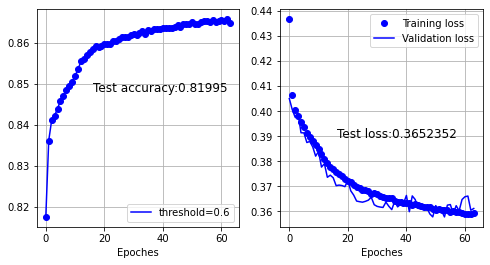

In [13]:
## plot precision and loss
precision = model_m_train.history['precision']
# precision_1 = model_m_train.history['precision_1']
val_precision = model_m_train.history['val_precision']
# val_precision_1 = model_m_train.history['val_precision_1']
loss = model_m_train.history['loss']
val_loss = model_m_train.history['val_loss']
epochs = range(len(precision))
fs = 12
fig, ax = plt.subplots(1,2, figsize=(8, 4))
ax[0].plot(epochs, precision, 'b', label='threshold=0.6')
ax[0].plot(epochs, precision, 'bo')
ax[0].legend()
ax[0].grid(True)
ax[0].set_xlabel('Epoches')
ax[0].annotate('Test accuracy:' + str(round(test_eval[1],5)),xy=(np.mean(epochs),np.mean(precision)),
                  xycoords='data',xytext=(-45,-45),textcoords='offset points',fontsize=fs)

ax[1].plot(epochs, loss, 'bo', label='Training loss')
ax[1].plot(epochs, val_loss, 'b', label='Validation loss')
#ax[1].set_title('Training (validation) precision and  loss')
ax[1].set_xlabel('Epoches')
ax[1].legend()
ax[1].grid(True)
ax[1].annotate('Test loss:' + str(round(test_eval[0],7)),xy=(np.mean(epochs),np.mean(loss)),
                  xycoords='data',xytext=(-45,45),textcoords='offset points',fontsize=fs)
plt.savefig(location + 'Precision'+SNR+'_1.pdf')

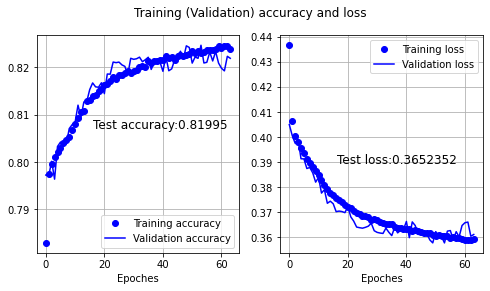

In [14]:
import matplotlib.pyplot as plt
accuracy = model_m_train.history['accuracy']
val_accuracy = model_m_train.history['val_accuracy']
loss = model_m_train.history['loss']
val_loss = model_m_train.history['val_loss']
epochs = range(len(accuracy))
fs = 12
fig, ax = plt.subplots(1,2, figsize=(8, 4))
ax[0].plot(epochs, accuracy, 'bo', label='Training accuracy')
ax[0].plot(epochs, val_accuracy, 'b', label='Validation accuracy')
#ax[0].set_title('Training and validation accuracy')
ax[0].legend()
ax[0].grid(True)
ax[0].set_xlabel('Epoches')
ax[0].annotate('Test accuracy:' + str(round(test_eval[1],5)),xy=(np.mean(epochs),np.mean(accuracy)),
                  xycoords='data',xytext=(-45,-45),textcoords='offset points',fontsize=fs)

ax[1].plot(epochs, loss, 'bo', label='Training loss')
ax[1].plot(epochs, val_loss, 'b', label='Validation loss')
ax[1].set_xlabel('Epoches')
ax[1].legend()
ax[1].grid(True)
ax[1].annotate('Test loss:' + str(round(test_eval[0],7)),xy=(np.mean(epochs),np.mean(loss)),
                  xycoords='data',xytext=(-45,45),textcoords='offset points',fontsize=fs)
fig.suptitle('Training (Validation) accuracy and loss ')
plt.savefig(location + 'SNR'+SNR+'_1.pdf')

In [15]:
## save model history
history=model_m_train.history
import csv
w = csv.writer(open(location + 'SNR'+SNR+'_1.csv', "w"))
for key, val in history.items():
    w.writerow([key, val])

In [16]:
#%% save model
# serialize model to YAML
from keras.models import model_from_yaml
model_yaml = model_m.to_yaml()
with open(location + 'model_m_SNR'+SNR+'_d1_updn_1.yaml', "w") as yaml_file:
    yaml_file.write(model_yaml)
# serialize weights to HDF5
model_m.save_weights(location + 'model_m_SNR'+SNR+'_d1_updn_1.h5')
print("Saved model to disk")

Saved model to disk


In [17]:
# Confusion matrix
pred_Y = model_m.predict(test_X)
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, cohen_kappa_score
from sklearn.metrics import classification_report
target_names = ["Cluster {}".format(i) for i in range(num_classes)]
print(classification_report(test_Y, pred_Y.round(), target_names=target_names))

              precision    recall  f1-score   support

   Cluster 0       0.90      0.77      0.83     64012
   Cluster 1       0.75      0.87      0.81     24027
   Cluster 2       0.74      0.89      0.81     23961

   micro avg       0.82      0.82      0.82    112000
   macro avg       0.80      0.85      0.82    112000
weighted avg       0.83      0.82      0.82    112000
 samples avg       0.82      0.82      0.82    112000



In [54]:
## calculate average precision score and precision recall curve
from sklearn.metrics import average_precision_score
from sklearn.metrics import precision_recall_curve 
# For each class
precision = dict()
recall = dict()
thresholds = dict()
average_precision = dict()
thresholds = dict()
n_classes = test_Y.shape[1]
for i in range(n_classes):
    precision[i], recall[i], thresholds[i] = precision_recall_curve(test_Y[:, i],
                                                        pred_Y[:, i])
    average_precision[i] = average_precision_score(test_Y[:, i], pred_Y[:, i])

# A "micro-average": quantifying score on all classes jointly
precision["micro"], recall["micro"], thresholds["micro"] = precision_recall_curve(test_Y.ravel(),
    pred_Y.ravel())
average_precision["micro"] = average_precision_score(test_Y, pred_Y,
                                                     average="micro")
print('Average precision score, micro-averaged over all classes: {0:0.2f}'
      .format(average_precision["micro"]))

Average precision score, micro-averaged over all classes: 0.92


(172892,)
(172892,)
(172891,)


Text(0, 0.5, '%')

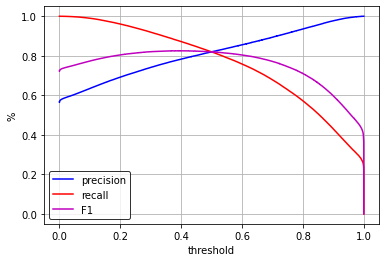

In [55]:
# print(np.shape(precision["micro"]))
# print(np.shape(recall["micro"]))
# print(np.shape(thresholds["micro"]))
## Average Decision thresholds
thresholds["micro"] = np.append(thresholds["micro"], 1) 
F1 = 2*precision["micro"]*recall["micro"]/(precision["micro"]+recall["micro"])
# queue_rate = [] 
# for threshold2 in thresholds2: 
#     queue_rate.append((pred_Y >= threshold2).mean()) 
plt.figure()
plt.step(thresholds["micro"], precision["micro"], 'b') 
plt.plot(thresholds["micro"], recall["micro"], 'r') 
plt.plot(thresholds["micro"], F1, 'm')
# plt.plot(thresholds2, queue_rate, 'c')
plt.grid(True)
leg = plt.legend(('precision', 'recall', 'F1'), frameon=True) 
leg.get_frame().set_edgecolor('k') 
plt.xlabel('threshold') 
plt.ylabel('%')

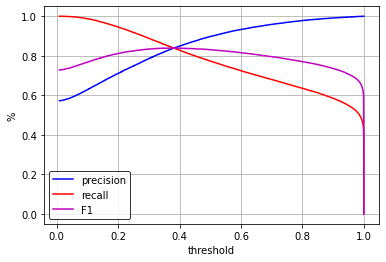

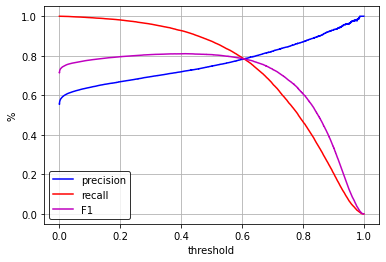

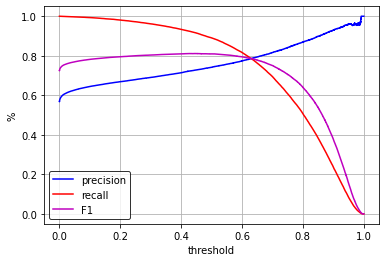

In [56]:
## Decision thresholds
for iw in range(3):
    thresholds[iw] = np.append(thresholds[iw], 1) 
    F1 = 2*precision[iw]*recall[iw]/(precision[iw]+recall[iw])
    # queue_rate = [] 
    # for threshold2 in thresholds2: 
    #     queue_rate.append((pred_Y >= threshold2).mean()) 
    plt.figure()
    plt.step(thresholds[iw], precision[iw], 'b') 
    plt.plot(thresholds[iw], recall[iw], 'r') 
    plt.plot(thresholds[iw], F1, 'm')
    # plt.plot(thresholds2, queue_rate, 'c')
    plt.grid(True)
    leg = plt.legend(('precision', 'recall', 'F1'), frameon=True) 
    leg.get_frame().set_edgecolor('k') 
    plt.xlabel('threshold') 
    plt.ylabel('%')
    plt.show

In [22]:
## save recall
data_threshold = [thresholds,precision,recall]
import csv

w = csv.writer(open(location + 'recall'+SNR+'_1.csv', "w"))
for key, val in recall.items():
    w.writerow([key, val])